In [1]:
import base64
from datetime import datetime, timedelta
import json
import os

from FH_Hydrosat import FH_Hydrosat
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj.crs import CRS
from pystac_client import Client
import seaborn as sns
from shapely.geometry import box, Point, Polygon

In [2]:
# Insitu point locations
insitu_met_points = {
    'Corn': [-121.5351, 38.1091],
    'Alfalfa': [-121.4993, 38.0992]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.5360, 38.1095],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

aoi_bbox = {
    'Alfalfa': [-121.5365, 38.1098, -121.5355, 38.1091],
    'Corn': [-121.5027, 38.0986, -121.5003, 38.1000]
}

In [3]:
# Define function to process Ameriflux data
def read_ameriflux(data_path):
    df = pd.read_csv(data_path, header=2, na_values=[-9999])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

In [4]:
# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')
bi1_data_path = os.path.join(data_path, 
                             'AMF_US-Bi1_BASE-BADM_8-5',
                             'AMF_US-Bi1_BASE_HH_8-5.csv')

In [5]:
# Explore bi1 data
bi1_df = read_ameriflux(bi1_data_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')

Data range from 2016-08-13 00:00:00 to 2022-05-26 23:30:00


In [6]:
# Authenticate and access catalog
with open(os.path.join('../secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [7]:
geom = {'type': 'Point', 'coordinates': crop_center_points['Alfalfa']}
start_date = "2016-08-13T00:00:00Z"
end_date = "2022-05-26T00:00:00Z"
pt = Point(geom['coordinates'])
aoi = aoi_bbox['Alfalfa']
collections_dict = {
    'collection': ['prepped_inputs_s2', 
                   'prepped_inputs_landsat', 
                   'prepped_inputs_mcd43a4', 
                   'prepped_inputs_mod21a1d',
                   'pydms_sharpened_modis',
                   'pydms_sharpened_landsat',
                   'starfm_predictions_modis_landsat'],
    'asset': ['surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'lst',
              'lst',
              'lst'],
    'tolerance': [40, 60, 1000, 2000, 1000, 40, 40],
    'red_band': [2, 2, 0, 0, 0,  0,  0],
    'nir_band': [6, 6, 1,  1,  0,  0, 0]
}
collections_df = pd.DataFrame(collections_dict)
collections_df

,collection,asset,tolerance,red_band,nir_band
0,prepped_inputs_s2,surface_reflectance,40,2,6
1,prepped_inputs_landsat,surface_reflectance,60,2,6
2,prepped_inputs_mcd43a4,surface_reflectance,1000,0,1
3,prepped_inputs_mod21a1d,surface_reflectance,2000,0,1
4,pydms_sharpened_modis,lst,1000,0,0
5,pydms_sharpened_landsat,lst,40,0,0
6,starfm_predictions_modis_landsat,lst,40,0,0


In [8]:
lst_collections = ["starfm_predictions_modis_landsat", 
                   "pydms_sharpened_landsat", 
                   "pydms_sharpened_modis"]

def lst_from_collection(collection):
    search = catalog.search(
            collections=collection,
            intersects=geom,
            # bbox=aoi,
            datetime=[start_date, end_date],
            max_items=500
        )

    s2_items = search.get_all_items()
    print(f'number of source items: {len(s2_items)}')

    assets = s2_items[0].to_dict()['assets'].keys()

    lst_full = FH_Hydrosat(s2_items, asset='lst')
    lst_dt = lst_full.datetime
    tolerance = collections_df.loc[collections_df['collection']==collection]['tolerance']
    lst_ts = lst_full.point_time_series_from_items(pt, tol=tolerance, nproc=6)

    lst_df = pd.DataFrame({'lst': lst_ts,
                            'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    lst_df.index = pd.to_datetime(lst_df['datetime'].dt.strftime('%Y-%m-%d'))

    lst_series = lst_df['lst'].astype('float')
    lst_series.name = collection
    return lst_series

In [9]:
lst_results = []
for collection in lst_collections:
    lst_series = lst_from_collection(collection)
    lst_results.append(lst_series)

number of source items: 405
using 6 processes to sample 405 assets
number of source items: 83
using 6 processes to sample 83 assets
number of source items: 488
using 6 processes to sample 488 assets


In [10]:
lst_df = pd.concat(lst_results, axis=1)
lst_df

,starfm_predictions_modis_landsat,pydms_sharpened_landsat,pydms_sharpened_modis
datetime,,,
2021-01-09,NaN,291.783142,287.582733
2021-01-10,285.783386,NaN,285.934814
2021-01-11,284.014282,NaN,282.486084
2021-01-12,NaN,NaN,NaN
2021-01-13,291.212372,NaN,290.839233
...,...,...,...
2022-05-22,311.753296,NaN,309.100555
2022-05-23,304.004272,NaN,301.255737
2022-05-24,311.733368,NaN,308.737488


In [11]:
tower_temp = bi1_df['TA'].groupby(pd.to_datetime(bi1_df.index.strftime('%Y-%m-%d'))).mean()
tower_temp = tower_temp + 273.15
tower_vpd = bi1_df['VPD_PI'].groupby(pd.to_datetime(bi1_df.index.strftime('%Y-%m-%d'))).mean()
tower_ndvi = bi1_df['NDVI'].groupby(pd.to_datetime(bi1_df.index.strftime('%Y-%m-%d'))).mean()
alfalfa_daily_params = pd.concat([tower_temp, tower_vpd, tower_ndvi], axis=1)
alfalfa_daily_params

,TA,VPD_PI,NDVI
start,,,
2016-08-13,297.241458,17.861470,0.724668
2016-08-14,296.193958,15.266970,0.737665
2016-08-15,293.123750,10.480059,0.538746
2016-08-16,294.591250,13.824319,0.538604
2016-08-17,295.337083,13.779257,0.513665
...,...,...,...
2022-05-22,294.229167,16.007252,0.615807
2022-05-23,295.474792,17.521602,0.620193
2022-05-24,297.564375,21.548453,0.630149


In [12]:
var_df = lst_df.merge(alfalfa_daily_params, how='left', left_index=True, right_index=True)
var_df['CATD_modis'] = var_df['pydms_sharpened_modis'] - var_df['TA']
var_df['CATD_landsat'] = var_df['pydms_sharpened_landsat'] - var_df['TA']
var_df['CATD_modis_starfm'] = var_df['starfm_predictions_modis_landsat'] - var_df['TA']
var_df.head()

,starfm_predictions_modis_landsat,pydms_sharpened_landsat,pydms_sharpened_modis,TA,VPD_PI,NDVI,CATD_modis,CATD_landsat,CATD_modis_starfm
datetime,,,,,,,,,
2021-01-09,NaN,291.783142,287.582733,278.547292,2.419832,0.408197,9.035441,13.23585,NaN
2021-01-10,285.783386,NaN,285.934814,277.512875,0.647978,0.408312,8.421939,NaN,8.270511
2021-01-11,284.014282,NaN,282.486084,277.599771,1.534866,0.421226,4.886313,NaN,6.414511
2021-01-12,NaN,NaN,NaN,279.418146,2.023000,0.424288,NaN,NaN,NaN
2021-01-13,291.212372,NaN,290.839233,283.591917,3.186558,0.429473,7.247317,NaN,7.620455


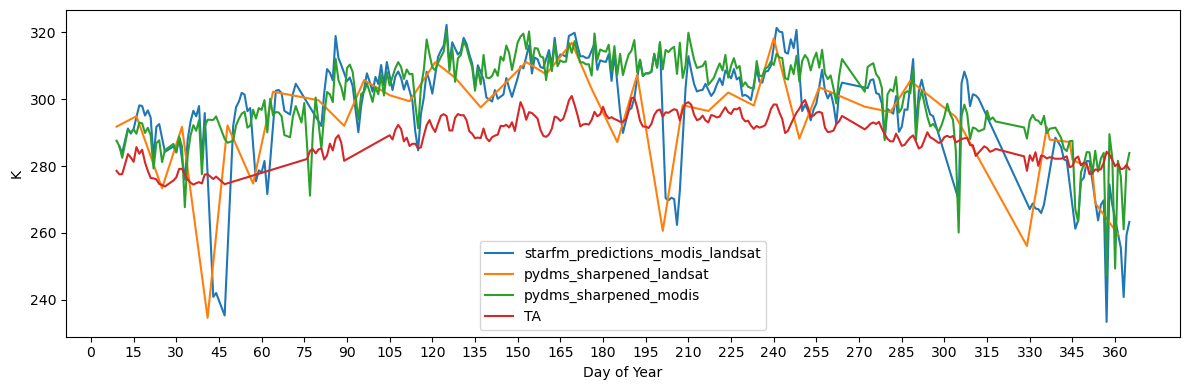

In [13]:
filt = (bi1_df['NDVI'] > 0.25) &  (bi1_df['NDVI'] < 0.75)
year = 2021

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# ax2 = ax.twinx()
# df = bi1_df.loc[filt]
# df_year = df.loc[df.index.year == year]
# # sns.lineplot(x=df_year.index.dayofyear,
# #             y=df_year['NDVI'],
# #             ax=ax, label='Tower NDVI').set(title=year)

var_df_year = var_df.loc[var_df.index.year == year]
for col in lst_collections:
    # filt = abs(var_df_year[col] - var_df_year['TA']) < 30
    filt = var_df_year[collection] > 240
    dff = var_df_year.loc[filt]
    sns.lineplot(x=dff.index.dayofyear,
            y=dff[col],
            ax=ax, label=col)
sns.lineplot(x=dff.index.dayofyear,
            y=dff['TA'],
            ax=ax, label='TA')
ax.set(xlabel='Day of Year', ylabel='K')

plt.xticks(range(0,365,15))
plt.tight_layout();

In [14]:
var_df_year.loc[var_df_year['TA'].isnull()].index

DatetimeIndex(['2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28',
               '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08',
               '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
               '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16',
               '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03',
               '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11',
               '2021-04-12', '2021-04-13', '2021-04-14'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [15]:
filt = var_df_year[collection] < 260
var_df_year.loc[filt].to_csv('../data/bad_dates.csv')

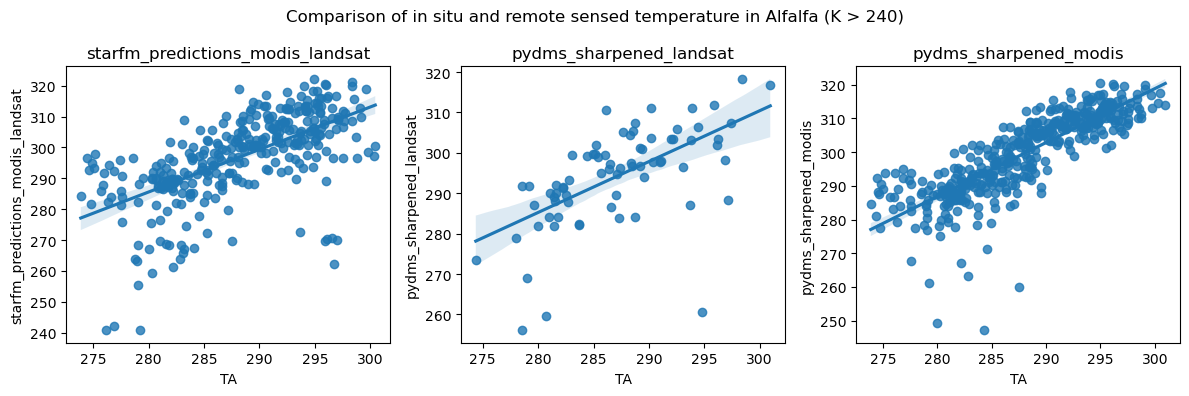

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for collection, ax in zip(lst_collections, axes.flatten()):
    filt = var_df[collection] > 240
    dff = var_df.loc[filt]
    sns.regplot(dff, y=collection, x='TA', ax=ax).set_title(collection)
plt.suptitle("Comparison of in situ and remote sensed temperature in Alfalfa (K > 240)")
plt.tight_layout();

<Axes: ylabel='Proportion'>

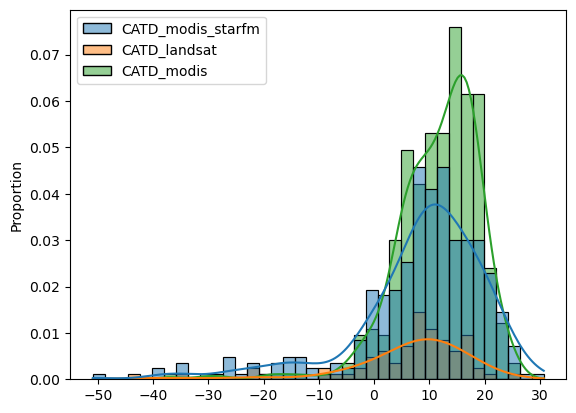

In [17]:
catds = ['CATD_modis_starfm', 'CATD_landsat', 'CATD_modis']
sns.histplot(dff[catds], stat='proportion', kde=True)

In [18]:
for collection in catds:
    var_df[collection + '_cor'] = var_df[collection] - 10
var_df.head()

,starfm_predictions_modis_landsat,pydms_sharpened_landsat,pydms_sharpened_modis,TA,VPD_PI,NDVI,CATD_modis,CATD_landsat,CATD_modis_starfm,CATD_modis_starfm_cor,CATD_landsat_cor,CATD_modis_cor
datetime,,,,,,,,,,,,
2021-01-09,NaN,291.783142,287.582733,278.547292,2.419832,0.408197,9.035441,13.23585,NaN,NaN,3.23585,-0.964559
2021-01-10,285.783386,NaN,285.934814,277.512875,0.647978,0.408312,8.421939,NaN,8.270511,-1.729489,NaN,-1.578061
2021-01-11,284.014282,NaN,282.486084,277.599771,1.534866,0.421226,4.886313,NaN,6.414511,-3.585489,NaN,-5.113687
2021-01-12,NaN,NaN,NaN,279.418146,2.023000,0.424288,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-13,291.212372,NaN,290.839233,283.591917,3.186558,0.429473,7.247317,NaN,7.620455,-2.379545,NaN,-2.752683


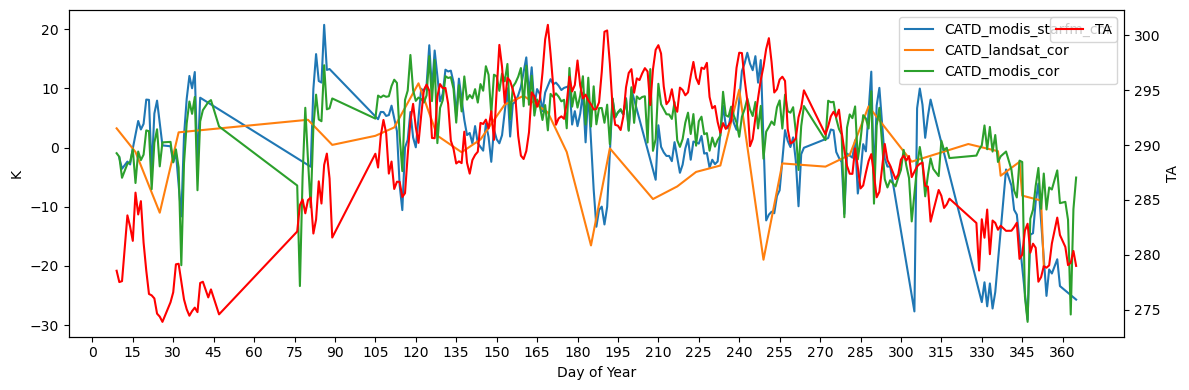

In [19]:
year = 2021
var_df_year = var_df.loc[var_df.index.year == year]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax2 = ax.twinx()
for collection in catds:
    filt = abs(var_df_year[collection + "_cor"]) < 30
    dff = var_df_year.loc[filt]
    sns.lineplot(x=dff.index.dayofyear,
            y=dff[collection + "_cor"],
            ax=ax, label=collection + "_cor")
sns.lineplot(x=dff.index.dayofyear,
            y=dff['TA'],
            ax=ax2, label='TA', color='r')
ax.set(xlabel='Day of Year', ylabel='K')

plt.xticks(range(0,365,15))
plt.tight_layout();

In [20]:
filt = (var_df_year.index.dayofyear > 120) & (var_df_year.index.dayofyear < 240)
var_df_season = var_df_year.loc[filt].copy()

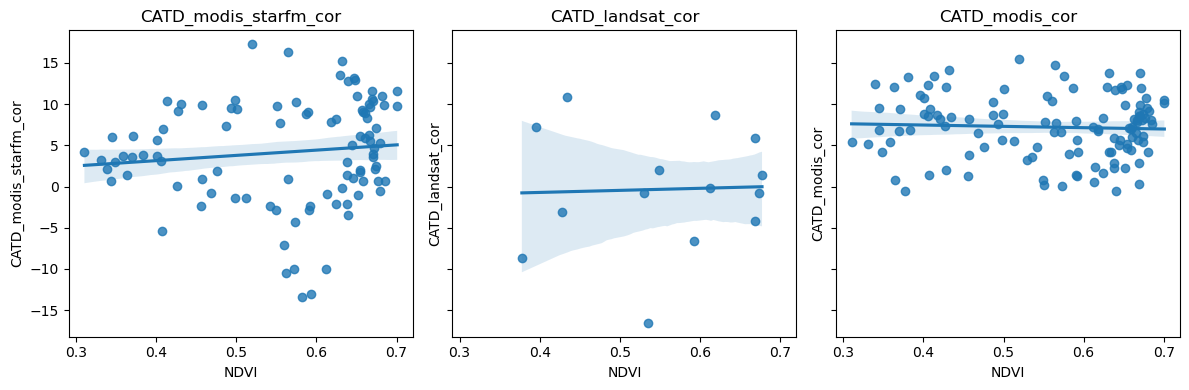

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
for collection, ax in zip(catds, axes.flatten()):
    filt = abs(var_df_season[collection + "_cor"]) < 30
    dff = var_df_season.loc[filt]
    sns.regplot(dff, y=(collection + "_cor"), x='NDVI', ax=ax).set_title(collection + "_cor")
# plt.suptitle("Comparison of in situ and remote sensed temperature in Alfalfa (excluding outliers)")
plt.tight_layout();

<Axes: xlabel='datetime', ylabel='NDVI'>

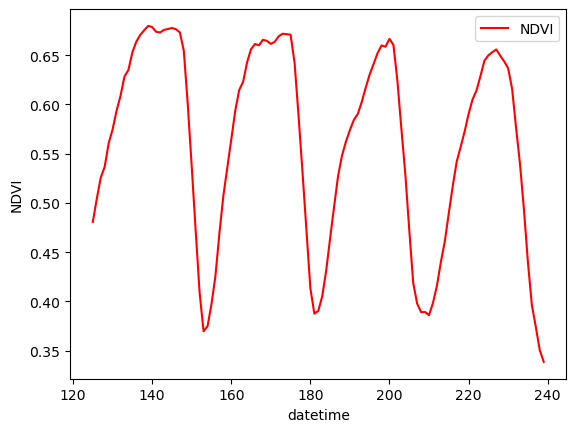

In [22]:
sns.lineplot(x=var_df_season.index.dayofyear,
            y=var_df_season['NDVI'].rolling(5).mean(),
            label='NDVI', color='r')
# sns.lineplot(x=var_df_season.index.dayofyear,
#             y=var_df_season['CATD_modis'],
#             label='CATD', color='r')

In [23]:
var_df_season['label'] = '#b0b0b0'

filt = var_df_season['NDVI'].rolling(5).mean() > 0.60
var_df_season.loc[filt, 'label'] = '#347354'

filt = var_df_season['NDVI'].rolling(5).mean() < 0.45
var_df_season.loc[filt, 'label'] = '#c1976d'

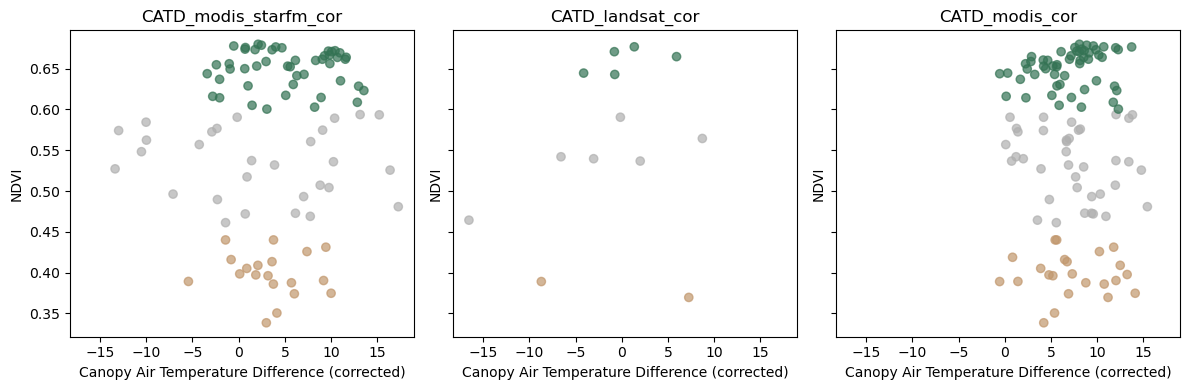

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
for collection, ax in zip(catds, axes.flatten()):
    filt = abs(var_df_season[collection + "_cor"]) < 30
    x = var_df_season['NDVI'].rolling(5).mean().loc[filt]
    y = var_df_season.loc[filt, collection + "_cor"]
    colors = var_df_season.loc[filt, 'label']
    ax.scatter(y=x, x=y, color=colors, alpha=0.7)
    ax.set_title(collection + "_cor")
    ax.set_ylabel('NDVI')
    ax.set_xlabel('Canopy Air Temperature Difference (corrected)')

plt.tight_layout();

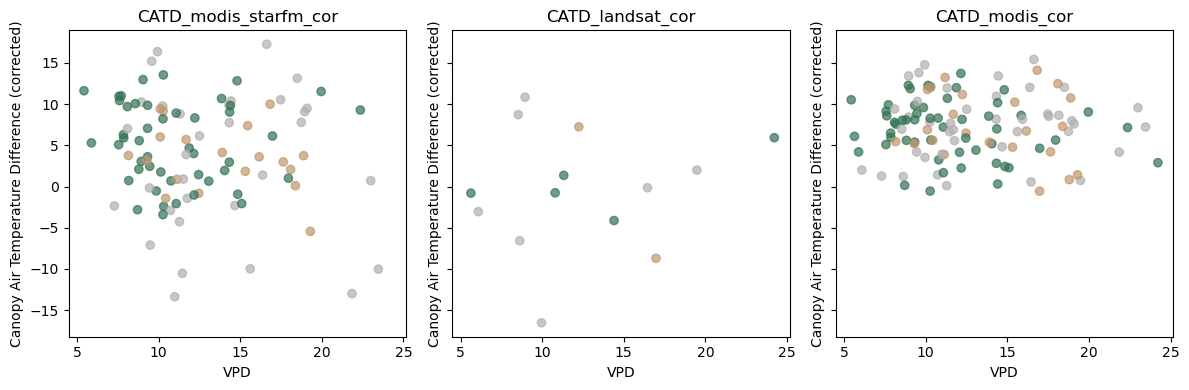

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
for collection, ax in zip(catds, axes.flatten()):
    filt = abs(var_df_season[collection + "_cor"]) < 30
    y = var_df_season['VPD_PI'].loc[filt]
    x = var_df_season.loc[filt, collection + "_cor"]
    colors = var_df_season.loc[filt, 'label']
    ax.scatter(y=x, x=y, color=colors, alpha=0.7)
    ax.set_title(collection + "_cor")
    ax.set_ylabel('Canopy Air Temperature Difference (corrected)')
    ax.set_xlabel('VPD')

plt.tight_layout();